## 从安然公司邮件中识别欺诈行为

### 项目概述

在2000年,安然公司是美国最大的公司之一。到2002时，由于广泛的公司欺诈，它已崩溃到破产中。在由此产生的联邦调查中，有相当数量机密信息进入公众眼前，包括成千上万的电子邮件和详细的财务数据。安然欺诈案是一个混乱而又引人入胜的大事件，从中可以发现几乎所有想像得到的企业违法行为。

在这个项目中，我将使用Python机器学习库：[scikit-learn](http://scikit-learn.org/) 和安然电子邮件和财务数据，来建立模型，识别欺诈行为。

本项目将运用到以下知识：
- 特征缩放和特征选择
- 

### 安然数据集

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


from feature_format import featureFormat
from feature_format import targetFeatureSplit

# 特征，第一个必须是'poi'，因为这是类标号
features_list = ["poi"]

# 加载数据集
data_dict = pickle.load(open("./data/final_project_dataset.pkl", "rb"))

In [2]:
print("There are ", len(data_dict.keys()), " executives in Enron Dataset.")
# print(data_dict.keys())
# print(data_dict['BUY RICHARD B'])

There are  146  executives in Enron Dataset.


原始数据集包含146条记录（人），14个财务数据特征，6个电子邮件特征，1个类标号（POI）；一共有18人被标记为嫌疑人（POI）

首先，我想看看我的数据，并检查它的异常值。我绘画了安然公司员工的工资和奖金散点图，并看到了数据中的一个孤立点。 

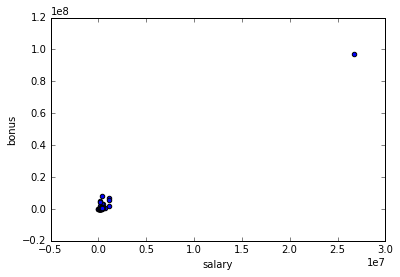

In [3]:
features = ["salary", "bonus"]

data = featureFormat(data_dict, features)
# plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

查询数据集后，发现这是一个总工资和奖金的数字，即把**TOTAL**也当做了一名员工，事实上，**TOTAL**是各个财务特征的总和，由于这是不明智的信息，我手动删除它。还发现还要两个离群值（SKILLING JEFFREY和LAY KENNETH），但我保留这些值，其实这已经标志着这两个经理参与诈骗。现在数据集看起来像这样： 

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


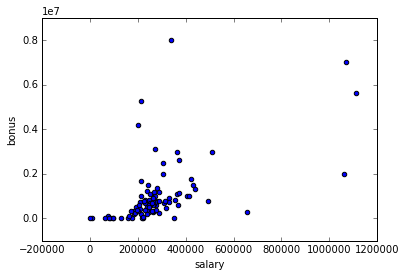

In [4]:
### 去除异常值
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### 删除数据集中'NaN'
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
### print top 4 salaries
print(outliers_final)

# plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

### 特征选择

清理后的数据从离群点，我不得不凭感觉选择有用的特征。首先，选择特征**from this person to poi**和**this person from poi**，应该与是否为POI和有关系，于是画出这两个特征的散点图：

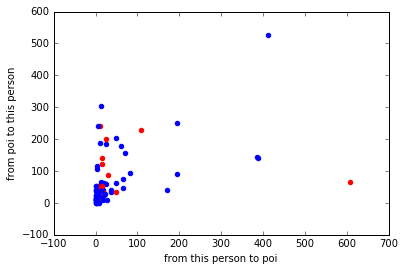

In [5]:
features_list = ["poi", "from_this_person_to_poi", "from_poi_to_this_person"]    
# 保存清理离群点后的数据
my_dataset = data_dict

# 原数据集为字典类型，python字典不能直接读入到sklearn分类或回归算法中，我编写了一些辅助函数`featureFormat()`，
# 它可以获取特征名的列表和数据字典，然后返回`numpy`数组,如果特征没有某个特定人员的值(即NaN)，此函数还会用 0替换特征值。
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r")
    else:
        plt.scatter(from_poi, to_poi, color="b")

plt.xlabel('from this person to poi')
plt.ylabel('from poi to this person')
plt.show()

但是从绘制出的散点图来看，特征**from this person to poi**和**this person from poi**并没有很强关系可以挖掘，以区分是否为POI。于是，创建两个新特征**fraction_from_poi_email**和**fraction_to_poi_email**，分别代表来自POI的电子邮件数占总收到的电子邮件数的比例、发生给POI的电子邮件数占总发送电子邮件数的比例：

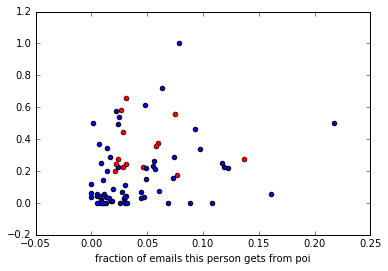

In [6]:
# 创建新特征
# new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()

从这个新的散点图，我们似乎可以发现红色的数据点（POI）聚集在散点图的中心。

为了找到最有效的特征进行分类，使用“决策树”的特征选择重要性排名的功能。选择功能是半手动迭代过程。我先把所有可能的功能为features_list然后开始删除逐一用评分值和人的直觉。

In [7]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(my_dataset, features_list)

# 分开类标号和特征
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=1)


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

t0 = time()

clf = DecisionTreeClassifier(random_state=2)
clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("Accuracy: ", accuracy_score(labels_test, pred))
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

print("Decision tree algorithm time:", round(time()-t0, 3), "s")



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print('Feature Ranking: ')
for i in range(16):
    print("{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]]))

Accuracy:  0.833333333333
Precision:  0.363636363636
Recall:  0.444444444444
Decision tree algorithm time: 0.004 s
Feature Ranking: 
1 feature salary (0.27089947089947086)
2 feature bonus (0.2659340659340658)
3 feature fraction_from_poi_email (0.22010582010582008)
4 feature fraction_to_poi_email (0.1245421245421247)
5 feature deferral_payments (0.11851851851851847)
6 feature total_payments (0.0)
7 feature loan_advances (0.0)
8 feature restricted_stock_deferred (0.0)
9 feature deferred_income (0.0)
10 feature total_stock_value (0.0)
11 feature expenses (0.0)
12 feature exercised_stock_options (0.0)
13 feature long_term_incentive (0.0)
14 feature shared_receipt_with_poi (0.0)
15 feature restricted_stock (0.0)
16 feature director_fees (0.0)


最后我选择10个特征:

    ["salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email", 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value']

In [8]:
features_list2 = ["salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email", 'deferral_payments', \
                 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value']
data2 = featureFormat(my_dataset, features_list2)

# 分开类标号和特征
labels2, features2 = targetFeatureSplit(data2)

### split data into training and testing datasets
from sklearn import cross_validation
features_train2, features_test2, labels_train2, labels_test2 = cross_validation.train_test_split(features2, labels2, test_size=0.5, random_state=1)

t0 = time()

clf = DecisionTreeClassifier(random_state=2)
clf.fit(features_train2,labels_train2)
pred = clf.predict(features_test2)
print("Accuracy: ", accuracy_score(labels_test2, pred))
# print("Precision: ", precision_score(labels_test2, pred))
# print("Recall: ", recall_score(labels_test2, pred))

print("Decision tree algorithm time:", round(time()-t0, 3), "s")

Accuracy:  0.361111111111
Decision tree algorithm time: 0.002 s


但这些特征的精度和召回率太低（小于0.3），所以我不得不改变我的战略和手动选择功能，给我的精度和召回率超过0.3。在这一次我使用我的算法精度评价因为只有有几个'poi'==1的数据在数据集中，所有最好的评指标为的准确率和召回率。在数据集只有18例中毒。有35人在“现实生活“，但由于各种原因，一半的人都不在该数据集。

最后我选择: 

    ["fraction_from_poi_email", "fraction_to_poi_email", “shared_receipt_with_poi”]

In [9]:
features_list3 = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", "shared_receipt_with_poi"]

data3 = featureFormat(my_dataset, features_list3)

# 分开类标号和特征
labels3, features3 = targetFeatureSplit(data3)

### split data into training and testing datasets
from sklearn import cross_validation
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features3, labels3, test_size=0.5, random_state=1)

### 算法选择

#### Logistic回归

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train3,labels_train3)
pred= clf.predict(features_test3)
print("Accuracy: ", accuracy_score(labels_test3, pred))
print("Precision: ", precision_score(labels_test3, pred))
print("Recall: ", recall_score(labels_test3, pred))

print("Logistic Regression algorithm time:", round(time()-t0, 3), "s")

Accuracy:  0.790697674419
Precision:  0.0
Recall:  0.0
Logistic Regression algorithm time: 0.265 s


/home/chauncey/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 决策树

In [11]:
t0 = time()

clf = DecisionTreeClassifier(random_state=4)
clf.fit(features_train3,labels_train3)
pred= clf.predict(features_test3)
print("Accuracy: ", accuracy_score(labels_test3, pred))
print("Precision: ", precision_score(labels_test3, pred))
print("Recall: ", recall_score(labels_test3, pred))

print("Decision tree algorithm time:", round(time()-t0, 3), "s")

Accuracy:  0.697674418605
Precision:  0.3
Recall:  0.333333333333
Decision tree algorithm time: 0.003 s


#### 朴素贝叶斯

In [12]:
# 尝试使用GaussianNB去预测
t0 = time()

clf = GaussianNB()
clf.fit(features_train3, labels_train3)
pred = clf.predict(features_test3)
print("Accuracy: ", accuracy_score(labels_test3, pred))
print("Precision: ", precision_score(labels_test3, pred))
print("Recall: ", recall_score(labels_test3, pred))

print("NB algorithm time:", round(time()-t0, 3), "s")

Accuracy:  0.813953488372
Precision:  1.0
Recall:  0.111111111111
NB algorithm time: 0.007 s


首先，我尝试Logistic回归、朴素贝叶斯精度比决策树算法（分别为0.83、0.81和0.81）。于是还要进一步优化。

### 验证

In [13]:
# 特征列表
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", 'shared_receipt_with_poi']

# 保存经过预处理的数据集
my_dataset = data_dict

# 原数据集为字典类型，python字典不能直接读入到sklearn分类或回归算法中，我编写了一些辅助函数`featureFormat()`，
# 它可以获取特征名的列表和数据字典，然后返回`numpy`数组,如果特征没有某个特定人员的值(即NaN)，此函数还会用 0替换特征值。
data = featureFormat(my_dataset, features_list)

# 分开类标号和特征
labels, features = targetFeatureSplit(data)


# 交叉验证
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=1)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    # make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

    
# 决策树
from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier(random_state=0)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print('accuracy before tuning ', score)

print("Decision tree algorithm time:", round(time()-t0, 3), "s")

### use manual tuning parameter min_samples_split
t0 = time()
clf2 = DecisionTreeClassifier(min_samples_split=5, random_state=0)
clf2 = clf2.fit(features_train,labels_train)
pred2 = clf2.predict(features_test)
print("done in %0.3fs" % (time() - t0))

print("Validating algorithm:")
print("accuracy after tuning = ", accuracy_score(labels_test, pred2))
print('precision = ', precision_score(labels_test,pred2))
print('recall = ', recall_score(labels_test,pred2))
#############################################################################



### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "wb") )
pickle.dump(data_dict, open("my_dataset.pkl", "wb") )
pickle.dump(features_list, open("my_feature_list.pkl", "wb"))

accuracy before tuning  0.928571428571
Decision tree algorithm time: 0.002 s
done in 0.002s
Validating algorithm:
accuracy after tuning =  0.928571428571
precision =  1.0
recall =  0.333333333333


### 讨论和结论

精度可以被解释为，一个人被确定为一个POI实际上是一个真正的POI的可能性。召回率，标识将在测试集的POI标志的可能性有多大。50%的时间，它会抓住那个人，50%的时间它不会。

这些数字是看上去相当不错的，但现实生活中，我们很难获取财务数据，这说明很难使用该模型去识别欺诈行为。改进的可能路径之一是挖掘的更多电子邮件数据。在该数据集的电子邮件特征汇总了所有的电子邮件数量，而并没有挖掘电子邮件的具体内容，所有通过挖掘每个人的邮件的文本，它是可能的，例如，特定词汇的使用/信息，就可以实现识别欺诈行为。